<a href="https://www.kaggle.com/code/aliniazi3/spotcancerai?scriptVersionId=262628569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/HAM10000_folders/mel/ISIC_0028582.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0027742.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0030032.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0031479.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033624.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033152.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0031417.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0025611.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0026352.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0026239.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033239.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0028075.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0028520.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0033878.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0027100.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0029056.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0031005.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0030970.jpg
/kaggle/input/HAM10000_folders/mel/ISIC_0032987.jpg
/kaggle/inpu


# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import cv2
import tensorflow as tf

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **DATA Preprocessing**

In [3]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma'
}

base_skin_dir = '/kaggle/input/HAM10000_folders'

# **Merge images from both folders into one dictionary**

In [4]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# image_id → folder/label (short code)
imageid_label_dict = {os.path.splitext(os.path.basename(x))[0]: os.path.basename(os.path.dirname(x))
                      for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# -------------------------------
# Create DataFrame
# -------------------------------
df = pd.DataFrame({
    'image_id': list(imageid_path_dict.keys()),
    'file_path': list(imageid_path_dict.values()),
    'label': [imageid_label_dict[i] for i in imageid_path_dict.keys()]
})

# Map label (short code) to full lesion type name
df['lesion_type'] = df['label'].map(lesion_type_dict)

# Shuffle dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check
print(df.head())
print(df['label'].value_counts())

       image_id                                          file_path label  \
0  ISIC_0025300  /kaggle/input/HAM10000_folders/nv/ISIC_0025300...    nv   
1  ISIC_0028503  /kaggle/input/HAM10000_folders/bkl/ISIC_002850...   bkl   
2  ISIC_0026937  /kaggle/input/HAM10000_folders/nv/ISIC_0026937...    nv   
3  ISIC_0032645  /kaggle/input/HAM10000_folders/mel/ISIC_003264...   mel   
4  ISIC_0028547  /kaggle/input/HAM10000_folders/nv/ISIC_0028547...    nv   

                     lesion_type  
0               Melanocytic nevi  
1  Benign keratosis-like lesions  
2               Melanocytic nevi  
3                       Melanoma  
4               Melanocytic nevi  
label
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


⚙️ Preprocessing all images...


100%|██████████| 10015/10015 [01:35<00:00, 104.93it/s]


✅ Preprocessing complete. All images saved to: /kaggle/working/preprocessed_images


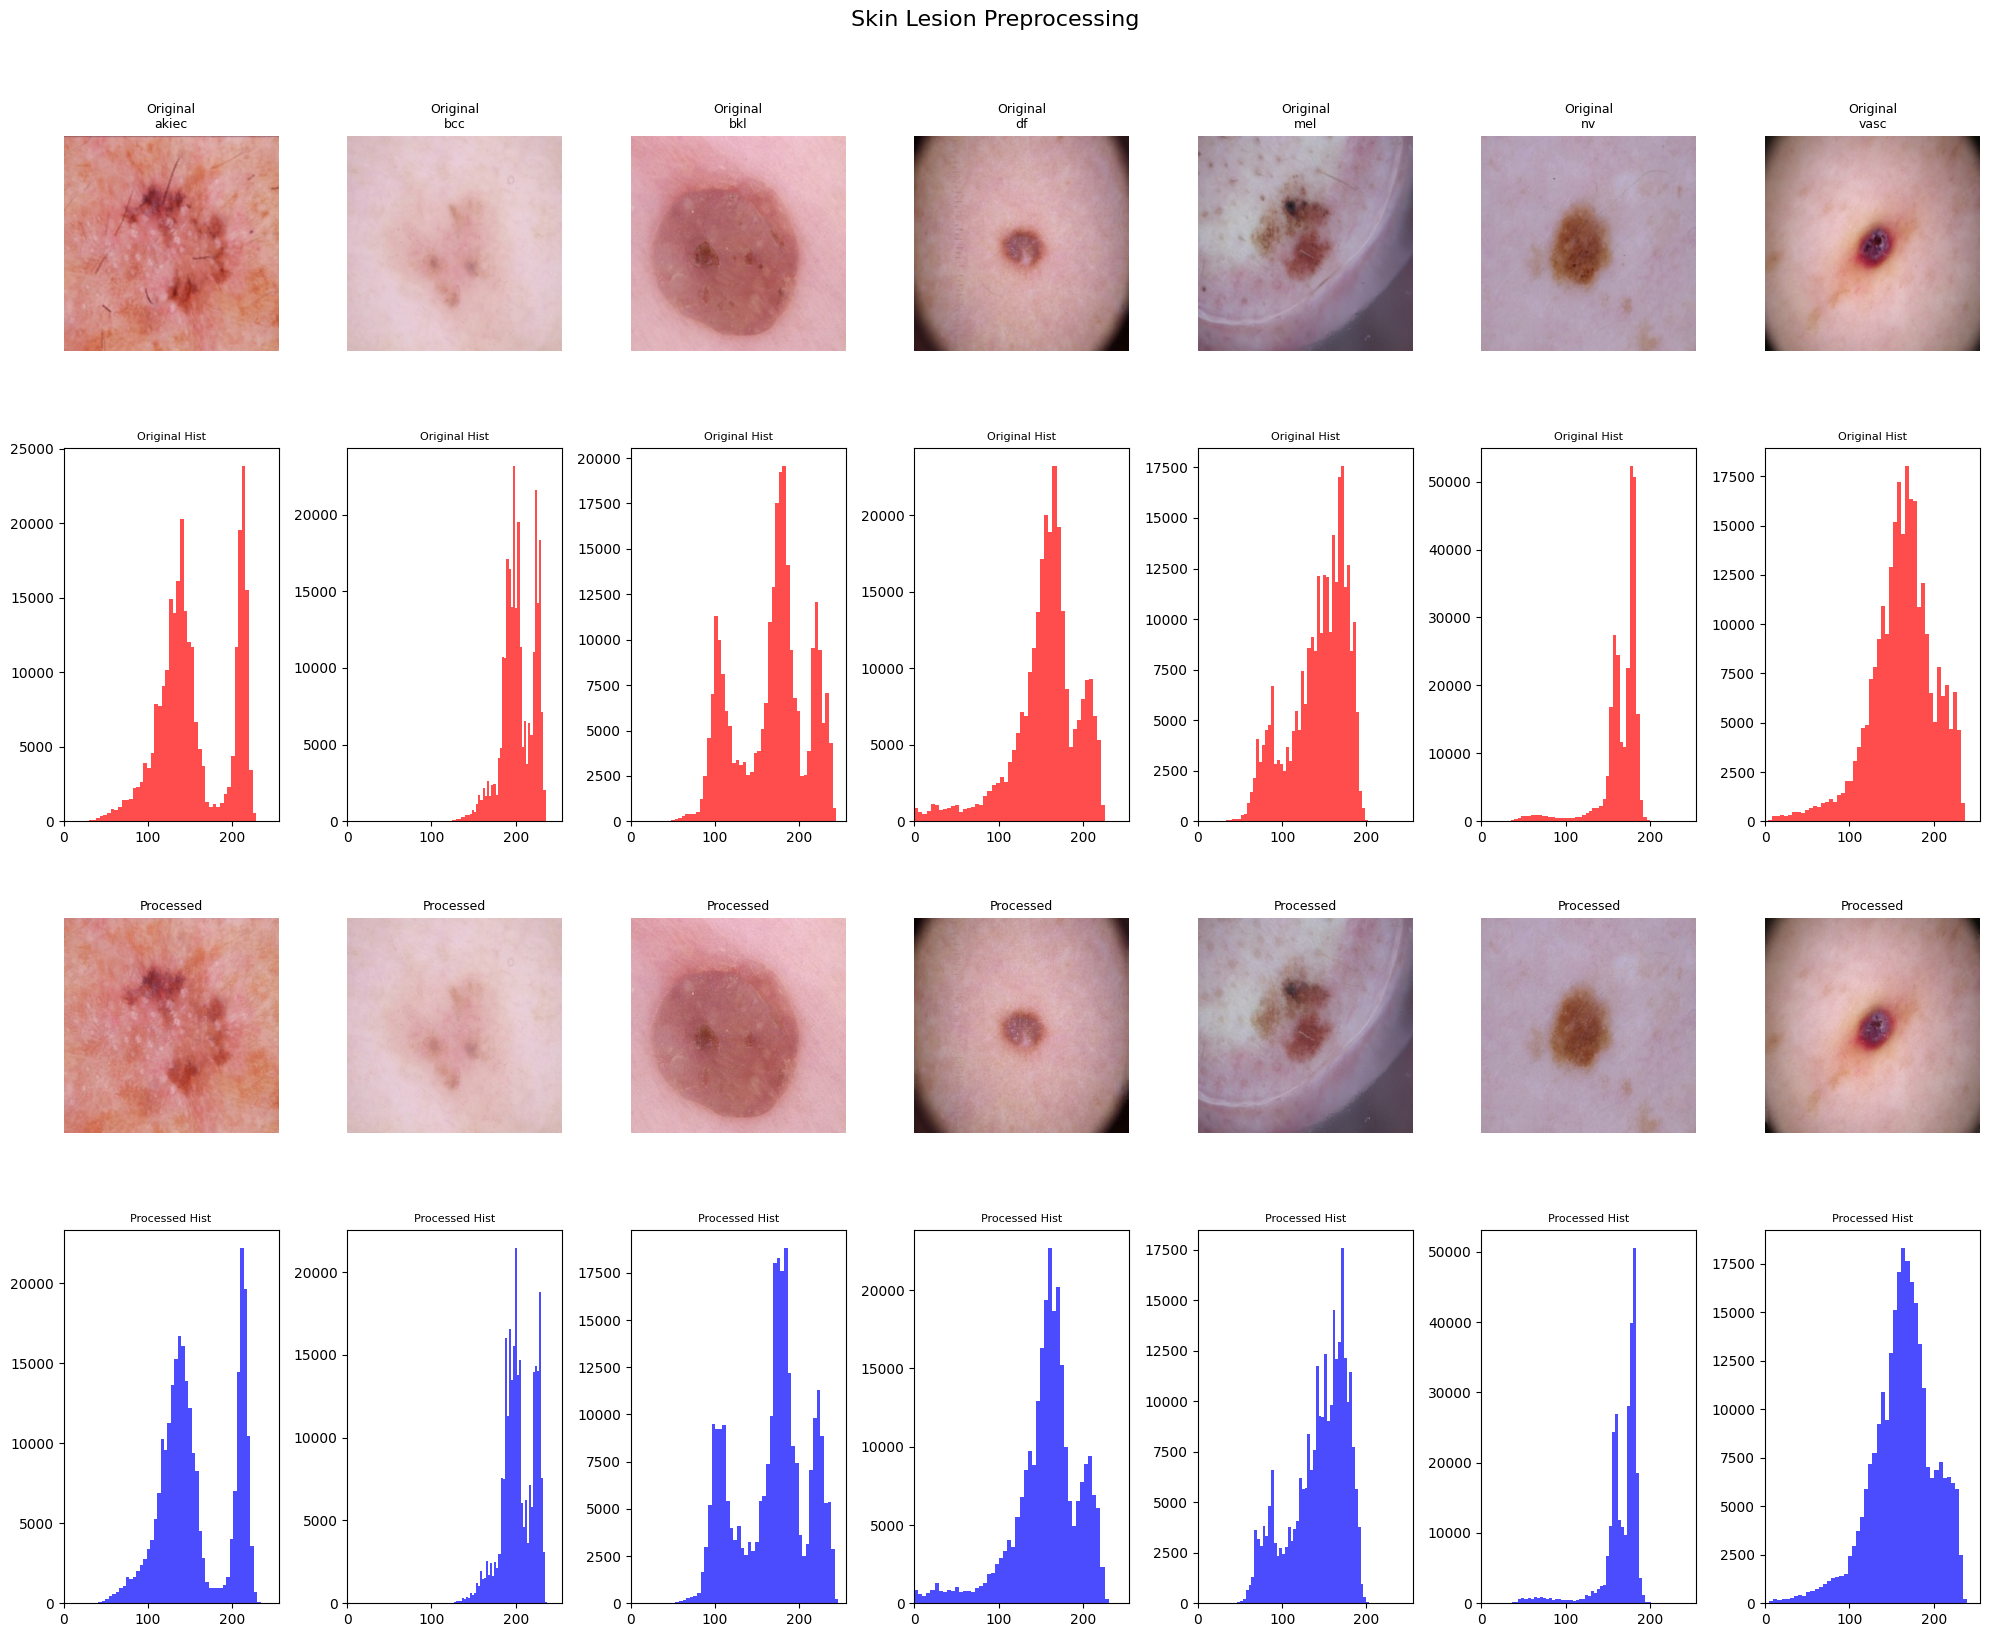

In [5]:
from tqdm import tqdm

# -------------------------
# Preprocessing function
# -------------------------
def preprocess(input_img, IMAGE_SIZE=300):
    """
    Preprocess skin lesion images:
    - Hair removal
    - Resize to IMAGE_SIZE
    """
    if isinstance(input_img, str):
        img = cv2.imread(input_img)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {input_img}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = input_img
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)

    # Hair removal
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11, 11))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, hair_mask = cv2.threshold(blackhat, 15, 255, cv2.THRESH_BINARY)
    cleaned = cv2.inpaint(img, hair_mask, 1, cv2.INPAINT_TELEA)

    # Resize
    cleaned_resized = cv2.resize(cleaned, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LANCZOS4)
    return cleaned_resized

# -------------------------
# Step 1: Preprocess all images
# -------------------------
output_dir = "/kaggle/working/preprocessed_images"
os.makedirs(output_dir, exist_ok=True)

processed_paths = []

print("⚙️ Preprocessing all images...")
for row in tqdm(df.itertuples(), total=len(df)):
    processed = preprocess(row.file_path)
    
    filename = os.path.basename(row.file_path)
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))  # save in BGR
    
    processed_paths.append(save_path)

df["processed_path"] = processed_paths
print("✅ Preprocessing complete. All images saved to:", output_dir)

# -------------------------
# Step 2: Visualization (7 samples, one per class)
# -------------------------
sample_images = df.groupby('label').first().reset_index()
num_classes = len(sample_images)

plt.figure(figsize=(20, 16))

for i, row in enumerate(sample_images.itertuples(), 1):
    # Original
    original = cv2.imread(row.file_path)
    original = cv2.cvtColor(cv2.resize(original, (300, 300)), cv2.COLOR_BGR2RGB)
    
    # Processed
    processed = cv2.imread(row.processed_path)
    processed = cv2.cvtColor(cv2.resize(processed, (300, 300)), cv2.COLOR_BGR2RGB)
    
    # Plot Original Image
    plt.subplot(4, num_classes, i)
    plt.imshow(original)
    plt.title(f"Original\n{row.label}", fontsize=9)
    plt.axis('off')
    
    # Original Histogram
    plt.subplot(4, num_classes, i + num_classes)
    plt.hist(original.ravel(), bins=50, color='red', alpha=0.7)
    plt.title("Original Hist", fontsize=8)
    plt.xlim(0, 255)
    
    # Processed Image
    plt.subplot(4, num_classes, i + 2*num_classes)
    plt.imshow(processed)
    plt.title("Processed", fontsize=9)
    plt.axis('off')
    
    # Processed Histogram
    plt.subplot(4, num_classes, i + 3*num_classes)
    plt.hist(processed.ravel(), bins=50, color='blue', alpha=0.7)
    plt.title("Processed Hist", fontsize=8)
    plt.xlim(0, 255)

plt.tight_layout()
plt.suptitle("Skin Lesion Preprocessing", y=1.02, fontsize=16)
plt.show()


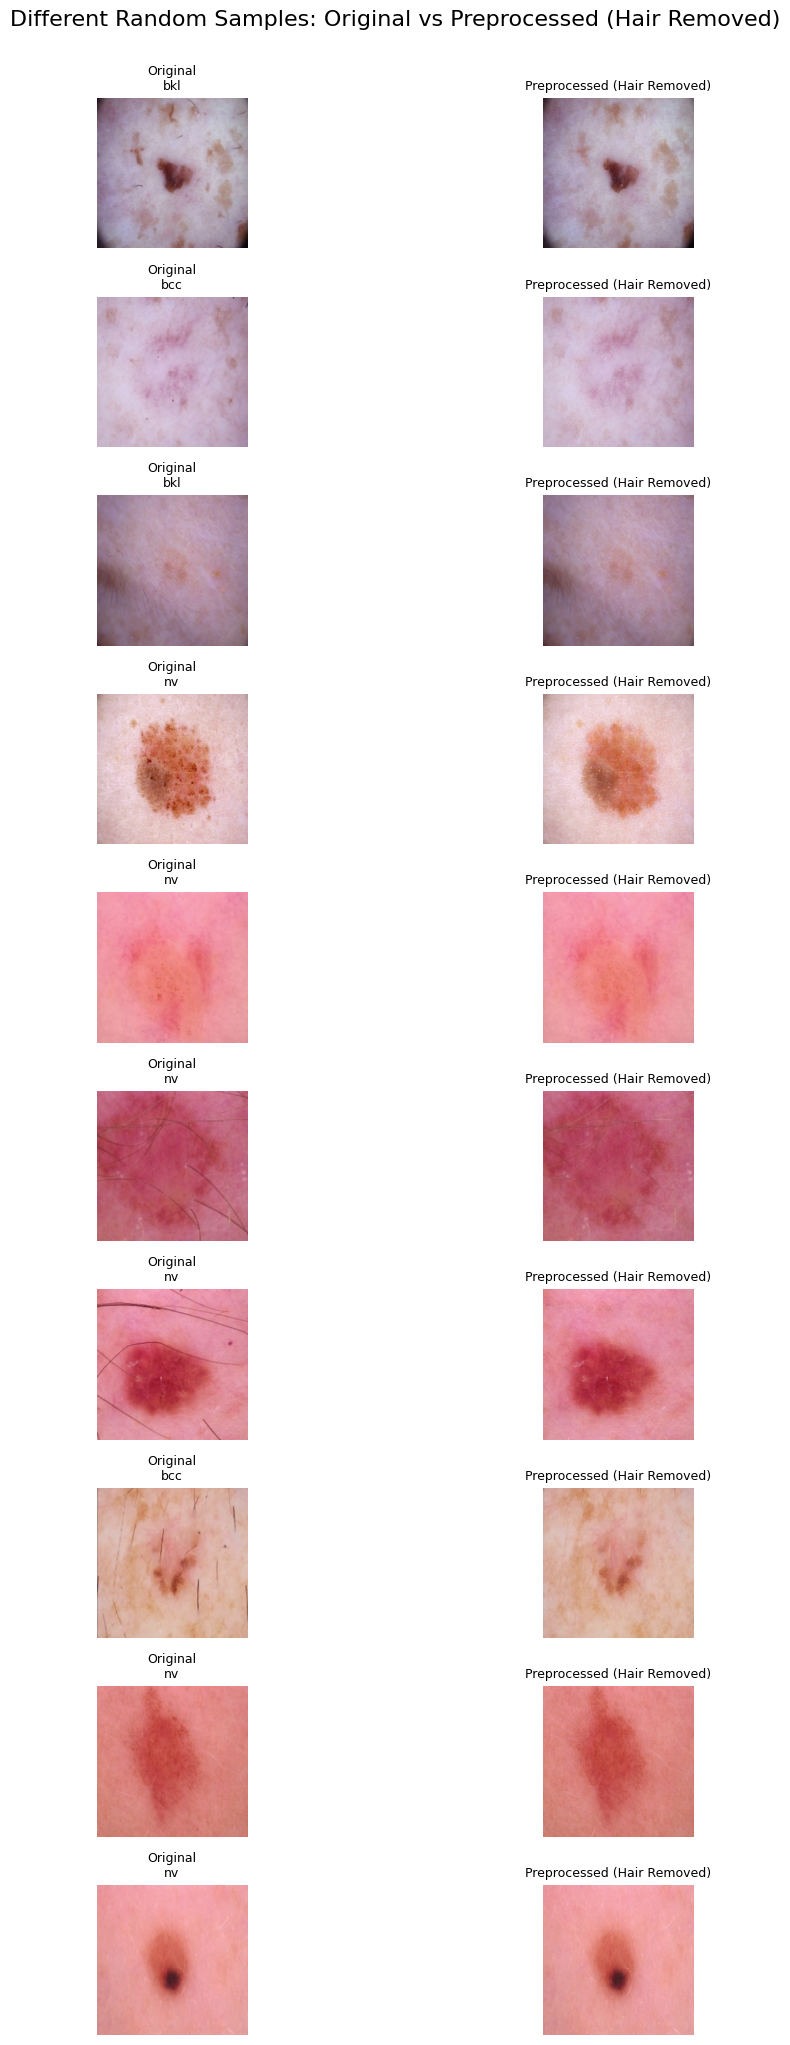

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Set a different random seed for variety
np.random.seed(123)  # Different from the previous seed (42)

# -------------------------
# Show 10 different random samples (Original vs Preprocessed)
# -------------------------

# Pick different random samples
n_samples = min(10, len(df))
sampled_df = df.sample(n=n_samples, random_state=123)  # Different seed

plt.figure(figsize=(12, n_samples * 2))

for idx, row in enumerate(sampled_df.itertuples()):
    # Read Original
    original = cv2.imread(row.file_path)
    original = cv2.cvtColor(cv2.resize(original, (300, 300)), cv2.COLOR_BGR2RGB)

    # Read Preprocessed
    processed = cv2.imread(row.processed_path)
    processed = cv2.cvtColor(cv2.resize(processed, (300, 300)), cv2.COLOR_BGR2RGB)

    # Plot Original
    plt.subplot(n_samples, 2, idx * 2 + 1)
    plt.imshow(original)
    plt.axis("off")
    plt.title(f"Original\n{row.label}", fontsize=9)

    # Plot Preprocessed
    plt.subplot(n_samples, 2, idx * 2 + 2)
    plt.imshow(processed)
    plt.axis("off")
    plt.title("Preprocessed (Hair Removed)", fontsize=9)

plt.tight_layout()
plt.suptitle("Different Random Samples: Original vs Preprocessed (Hair Removed)", y=1.02, fontsize=16)
plt.show()

# **Frequency Distribution of Classes**

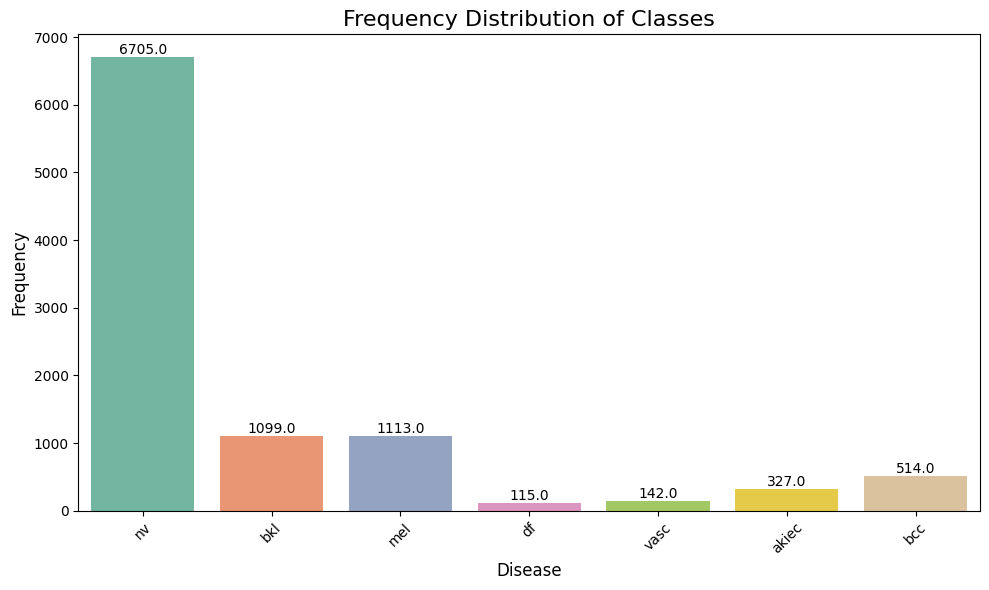

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the correct DataFrame and column name
plt.figure(figsize=(10,6))
ax = sns.countplot(x='label', data=df, palette='Set2')  # replace 'label' with 'dx' if needed

plt.xlabel('Disease', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Classes', fontsize=16)
plt.xticks(rotation=45)

# Annotate counts on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# **Data Splitting**

In [8]:
from sklearn.model_selection import train_test_split

# Use correct column names
X = df['file_path'].values      # image paths
y = df['label'].values          # class labels (short codes)

# 1. Split 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Split temp into 10% val and 20% test (relative to original)
# temp is 30% of original, so to get val=10% and test=20% we split temp as 1/3 val, 2/3 test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

# Check sizes
print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.2%})")


Train size: 7010 (70.00%)
Validation size: 1001 (10.00%)
Test size: 2004 (20.01%)


# **Combine into DataFrames**

In [9]:
train_df = pd.DataFrame({'path': X_train, 'label': y_train})
val_df   = pd.DataFrame({'path': X_val,   'label': y_val})
test_df  = pd.DataFrame({'path': X_test,  'label': y_test})

# Convert labels to string for generators
for d in [train_df, val_df, test_df]:
    d['label'] = d['label'].astype(str)

# -------------------
# Map to preprocessed path
# -------------------
preprocessed_dir = "/kaggle/working/preprocessed_images"

for d in [train_df, val_df, test_df]:
    d['processed_path'] = d['path'].apply(lambda x: os.path.join(preprocessed_dir, os.path.basename(x)))

# ✅ Now use `processed_path` column for your generators
print("Example preprocessed path:", train_df['processed_path'].iloc[0])

Example preprocessed path: /kaggle/working/preprocessed_images/ISIC_0032050.jpg


# **Augmentation**

In [10]:
class_counts = train_df['label'].value_counts()
max_count = class_counts.max()
print("Original class distribution:\n", class_counts)

Original class distribution:
 label
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64


In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

# Use training labels
y_train_labels = train_df['label'].values

# Get unique classes
classes = np.unique(y_train_labels)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_labels
)

# Convert to dictionary for Keras
class_weights_dict = dict(zip(classes, class_weights))

print("Class weights:")
for cls, weight in class_weights_dict.items():
    print(f"{cls}: {weight:.2f}")


Class weights:
akiec: 4.37
bcc: 2.78
bkl: 1.30
df: 12.36
mel: 1.29
nv: 0.21
vasc: 10.12


In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil
from collections import Counter
import random

# ------------------------
# Settings
# ------------------------
balanced_dir = "/kaggle/working/balanced_train_augmented"
os.makedirs(balanced_dir, exist_ok=True)

# Current class distribution
class_counts = train_df['label'].value_counts()
majority_class = class_counts.idxmax()
majority_count = class_counts.max()

print("Majority class:", majority_class, "with", majority_count, "samples")

balanced_paths = []
balanced_labels = []

# ------------------------
# Helper Augmentation Functions
# ------------------------
def rotate_image(image, angle):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

def zoom_image(image, factor=1.2):
    h, w = image.shape[:2]
    nh, nw = int(h * factor), int(w * factor)
    resized = cv2.resize(image, (nw, nh))

    if factor > 1:  # zoom in → crop center
        startx = nw//2 - w//2
        starty = nh//2 - h//2
        return resized[starty:starty+h, startx:startx+w]
    else:  # zoom out → pad with reflection
        pad_x = (w - nw) // 2
        pad_y = (h - nh) // 2
        return cv2.copyMakeBorder(resized, pad_y, h - nh - pad_y, pad_x, w - nw - pad_x, cv2.BORDER_REFLECT_101)


def flip_image(image, mode="h"):
    if mode == "h":
        return cv2.flip(image, 1)
    elif mode == "v":
        return cv2.flip(image, 0)
    elif mode == "hv":
        return cv2.flip(image, -1)
    return image

def adjust_brightness(image, factor=1.2):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[...,1] = hsv[...,1]*factor
    hsv[...,1][hsv[...,1] > 255] = 255
    hsv[...,2] = hsv[...,2]*factor
    hsv[...,2][hsv[...,2] > 255] = 255
    return cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)

def adjust_contrast(image, factor=1.2):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=factor, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def gamma_correction(image, gamma=1.5):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def add_noise(image):
    noise = np.random.normal(0, 25, image.shape).astype(np.int16)  # keep signed first
    noisy = image.astype(np.int16) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def random_crop(image, crop_ratio=0.8):
    """
    Random crop function
    crop_ratio: ratio of original image to keep (0.0 to 1.0)
    """
    h, w = image.shape[:2]
    crop_h, crop_w = int(h * crop_ratio), int(w * crop_ratio)
    
    # Random starting position
    start_y = random.randint(0, h - crop_h)
    start_x = random.randint(0, w - crop_w)
    
    # Crop and resize back to original size
    cropped = image[start_y:start_y+crop_h, start_x:start_x+crop_w]
    return cv2.resize(cropped, (w, h))

# ------------------------
# Randomized Wrappers
# ------------------------
def random_rotate(img):
    angle = random.choice([15, 30, 45, 60, 90, -15, -30, -45])
    return rotate_image(img, angle)

def random_zoom(img):
    factor = random.uniform(0.8, 1.3)
    return zoom_image(img, factor)

def random_flip(img):
    return flip_image(img, random.choice(["h", "v", "hv"]))

def random_brightness(img):
    factor = random.uniform(0.7, 1.4)
    return adjust_brightness(img, factor)

def random_contrast(img):
    factor = random.uniform(1.0, 2.0)
    return adjust_contrast(img, factor)

def random_gamma(img):
    gamma = random.uniform(0.7, 1.5)
    return gamma_correction(img, gamma)

def random_crop_wrapper(img):
    crop_ratio = random.uniform(0.7, 0.95)
    return random_crop(img, crop_ratio)

# ------------------------
# Augmentation list (including crop)
# ------------------------
augmentations = [
    ("rot", random_rotate),
    ("zoom", random_zoom),
    ("flip", random_flip),
    ("bright", random_brightness),
    ("contrast", random_contrast),
    ("gamma", random_gamma),
    ("noise", add_noise),
    ("crop", random_crop_wrapper)
]

def apply_random_augmentation_combinations(img, num_augmentations=2):
    """
    Apply random combinations of augmentations to an image
    num_augmentations: number of augmentations to apply (1 to len(augmentations))
    """
    # Randomly select which augmentations to apply
    selected_augs = random.sample(augmentations, min(num_augmentations, len(augmentations)))
    
    augmented_img = img.copy()
    aug_names = []
    
    for aug_name, aug_fn in selected_augs:
        augmented_img = aug_fn(augmented_img)
        aug_names.append(aug_name)
    
    return augmented_img, "_".join(aug_names)

def apply_single_random_augmentation(img):
    """
    Apply a single random augmentation to an image
    """
    aug_name, aug_fn = random.choice(augmentations)
    augmented_img = aug_fn(img)
    return augmented_img, aug_name

# ------------------------
# Balance dataset - ENSURING EACH IMAGE GETS AUGMENTED
# ------------------------
for label, count in class_counts.items():
    class_paths = train_df[train_df['label'] == label]['processed_path'].values
    target_count = majority_count

    # Create subfolder for this class
    class_dir = os.path.join(balanced_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    # Copy original images (from preprocessed path)
    for img_path in class_paths:
        fname = os.path.basename(img_path)
        dst = os.path.join(class_dir, fname)
        shutil.copy(img_path, dst)
        balanced_paths.append(dst)
        balanced_labels.append(label)

    # Oversample with augmentations if minority
    if count < target_count:
        n_needed = target_count - count
        
        # Calculate how many augmentations per original image
        augs_per_image = max(1, n_needed // count)
        remainder = n_needed % count
        
        print(f"Class {label}: Need {n_needed} augmentations, {augs_per_image} per image + {remainder} extra")
        
        # Apply augmentations to each original image
        for img_idx, img_path in enumerate(class_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Number of augmentations for this specific image
            current_augs = augs_per_image + (1 if img_idx < remainder else 0)
            
            for aug_idx in range(current_augs):
                # Randomly choose between single augmentation or combination
                use_combination = random.choice([True, False])
                
                if use_combination:
                    # Apply 2-3 random augmentations
                    num_augs = random.randint(2, 3)
                    aug_img, aug_str = apply_random_augmentation_combinations(img, num_augs)
                else:
                    # Apply single random augmentation
                    aug_img, aug_str = apply_single_random_augmentation(img)

                out_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_{aug_str}_{img_idx}_{aug_idx}.jpg"
                out_path = os.path.join(class_dir, out_name)
                cv2.imwrite(out_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

                balanced_paths.append(out_path)
                balanced_labels.append(label)

balanced_train_df = pd.DataFrame({
    "path": balanced_paths,
    "label": balanced_labels
})

print("\n✅ Balanced dataset distribution:")
print(balanced_train_df['label'].value_counts())
print("📂 Example balanced path:", balanced_train_df['path'].iloc[0])
print(f"📊 Total images after balancing: {len(balanced_train_df)}")

Majority class: nv with 4693 samples
Class mel: Need 3914 augmentations, 5 per image + 19 extra
Class bkl: Need 3924 augmentations, 5 per image + 79 extra
Class bcc: Need 4333 augmentations, 12 per image + 13 extra
Class akiec: Need 4464 augmentations, 19 per image + 113 extra
Class vasc: Need 4594 augmentations, 46 per image + 40 extra
Class df: Need 4612 augmentations, 56 per image + 76 extra

✅ Balanced dataset distribution:
label
nv       4693
mel      4693
bkl      4693
bcc      4693
akiec    4693
vasc     4693
df       4693
Name: count, dtype: int64
📂 Example balanced path: /kaggle/working/balanced_train_augmented/nv/ISIC_0032050.jpg
📊 Total images after balancing: 32851


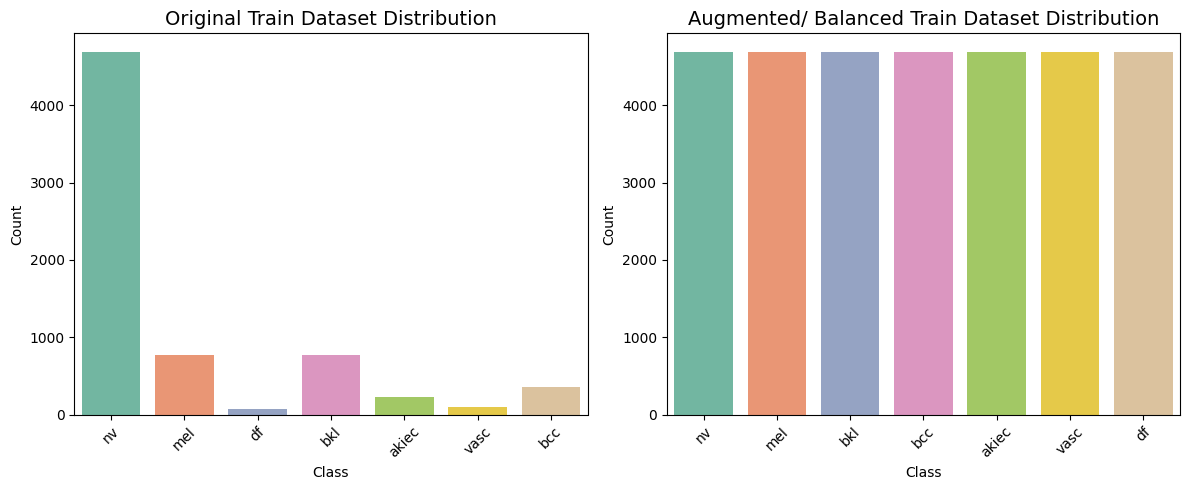

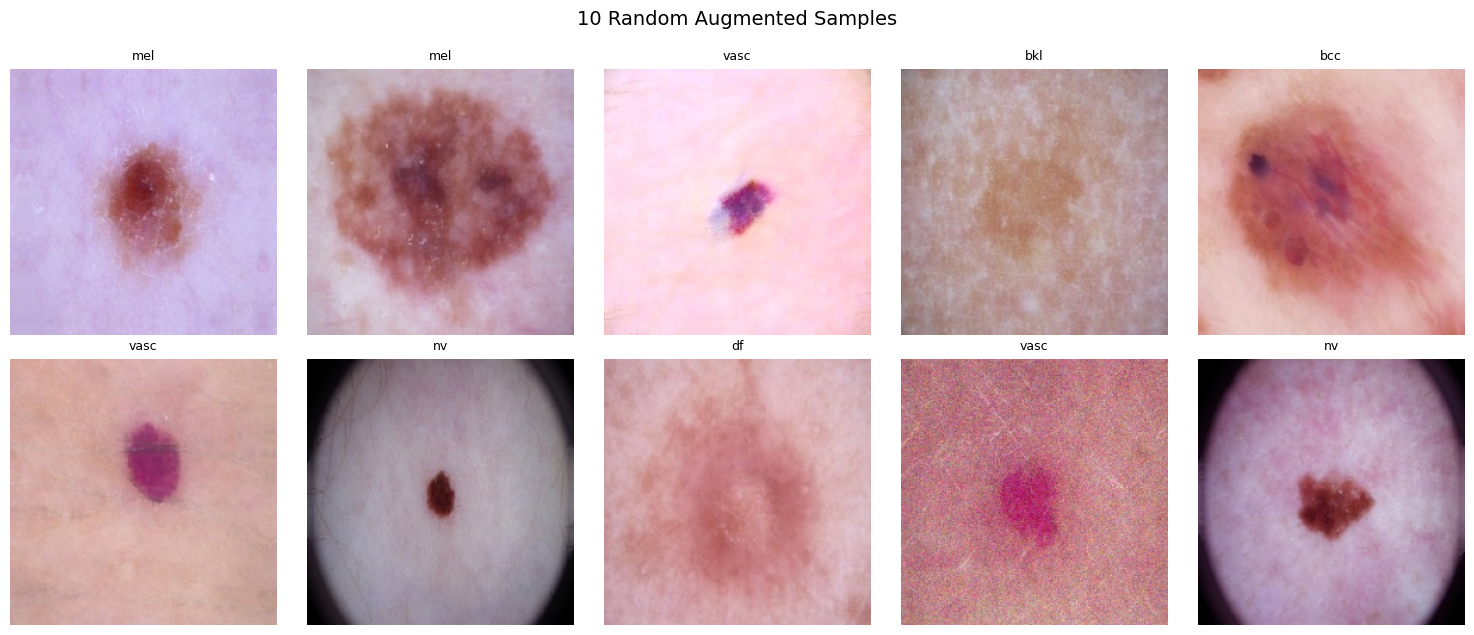

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np

# -------------------------------
# 1. Plot original vs balanced class distribution
# -------------------------------
plt.figure(figsize=(12,5))

# Original train distribution
plt.subplot(1,2,1)
sns.countplot(x='label', data=train_df, palette='Set2')
plt.title("Original Train Dataset Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Balanced (augmented) train distribution
plt.subplot(1,2,2)
sns.countplot(x='label', data=balanced_train_df, palette='Set2')
plt.title("Augmented/ Balanced Train Dataset Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
import cv2
import random

# -------------------------------
# Show 10 random augmented samples
# -------------------------------
sampled_df = balanced_train_df.sample(n=10, random_state=42)

plt.figure(figsize=(15, 6))

for idx, row in enumerate(sampled_df.itertuples()):
    img = cv2.imread(row.path)  
    img = cv2.cvtColor(cv2.resize(img, (224,224)), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{row.label}", fontsize=9)

plt.tight_layout()
plt.suptitle("10 Random Augmented Samples", y=1.05, fontsize=14)
plt.show()


# **One-hot encode the labels And Data Generators (for categorical classification)**

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMAGE_SIZE = 300   # EfficientNet default input size
BATCH_SIZE = 32

# Train generator (no online augmentation, just preprocess)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    x_col="path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# Validation generator
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="processed_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Test generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="processed_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# -----------------------
# Debug Info
# -----------------------
print("✅ Train samples:", train_generator.samples)
print("✅ Validation samples:", val_generator.samples)
print("✅ Test samples:", test_generator.samples)
print("✅ Classes:", train_generator.class_indices)


Found 32851 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 2004 validated image filenames belonging to 7 classes.
✅ Train samples: 32851
✅ Validation samples: 1001
✅ Test samples: 2004
✅ Classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


# **Build and compile the EfficientNetB5 model**

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


# ------------------------
# Custom Focal Loss
# ------------------------
def categorical_focal_loss(gamma=2.0, alpha=None):
    """
    Multiclass focal loss with per-class alpha weighting.
    alpha: list/array of weights for each class (len = num_classes).
    gamma: focusing parameter.
    """
    alpha = tf.constant(alpha, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)

        # apply alpha per class
        alpha_factor = y_true * alpha

        # focal weight
        focal_factor = K.pow(1 - y_pred, gamma)

        loss = alpha_factor * focal_factor * cross_entropy
        return K.sum(loss, axis=1)

    return loss


import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + 1e-7))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# ------------------------
# Model Architecture
# ------------------------
IMAGE_SIZE = 300
num_classes = 7

base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Fine-tuning: freeze most layers
for layer in base_model.layers[:300]:
    layer.trainable = False
for layer in base_model.layers[300:]:
    layer.trainable = True

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

class_weights = {
    "akiec": 4.37,
    "bcc": 2.78,
    "bkl": 1.30,
    "df": 12.36,
    "mel": 1.29,
    "nv": 0.21,
    "vasc": 10.12
}

# order of labels must match your dataset’s encoding
alpha_vector = [4.37, 2.78, 1.30, 12.36, 1.29, 0.21, 10.12]

# normalize so average = 1
alpha_vector = [w / (sum(alpha_vector) / len(alpha_vector)) for w in alpha_vector]

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0, alpha=alpha_vector),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top3_acc"),
    ]
)


# ------------------------
# Model Summary
# ------------------------
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 300, 300, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 300, 300, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 11,212,342 (42.77 MB)

 Trainable params: 7,340,409 (28.00 MB)

 Non-trainable params: 3,871,933 (14.77 MB)

# **Train the model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2,min_lr=1e-7)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict 
)


Epoch 1/20
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 335s 266ms/step - accuracy: 0.3501 - auc: 0.7175 - loss: 1.0841 - top3_acc: 0.6620 - val_accuracy: 0.3377 - val_auc: 0.7429 - val_loss: 0.2349 - val_top3_acc: 0.7283 - learning_rate: 1.0000e-04
Epoch 2/20
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 224s 218ms/step - accuracy: 0.5683 - auc: 0.8811 - loss: 0.3755 - top3_acc: 0.8608 - val_accuracy: 0.3996 - val_auc: 0.7774 - val_loss: 0.2041 - val_top3_acc: 0.7502 - learning_rate: 1.0000e-04
Epoch 3/20
 354/1027 ━━━━━━━━━━━━━━━━━━━━ 2:23 213ms/step - accuracy: 0.6302 - auc: 0.9087 - loss: 0.2916 - top3_acc: 0.8888

In [ ]:
# Example: Find epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['accuracy']) + 1  # +1 because indexing starts from 0
best_acc = history.history['accuracy'][best_epoch - 1]

print(f"Best Epoch: {best_epoch}")
print(f"Accuracy at Best Epoch: {best_acc:.4f}")

In [ ]:
import os

# Create directory
save_dir = '/kaggle/working/my_model'
os.makedirs(save_dir, exist_ok=True)

# Save model 
model.save(os.path.join(save_dir, 'B5_Model.h5'))

# **Plot Training History (Accuracy & Loss)**

In [ ]:
# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

# Precision curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluate the Model on Test Data**

In [ ]:
results = model.evaluate(test_generator)
print(dict(zip(model.metrics_names, results)))


# **Confusion Metrix**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Get predicted probabilities
y_prob = model.predict(test_generator)

# Step 2: Convert probabilities to predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# Step 3: Get true labels from the generator
y_true = test_generator.classes

# Step 4: Get label names from generator
labels = list(test_generator.class_indices.keys())

# Step 5: Print Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Step 6: Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()